# Predicting Stock Prices using Machine Learning

A stock is a form of security that indicates the holder has a portion of ownership in a corporation.

Predicting how the stock market will perform is very hard in general. There are so many factors involved in the prediction – Economic growth,Interest rates,Bandwagon effect,stability etc. All these aspects combine to make share prices volatile and very difficult to predict with a high degree of accuracy.

Using features like the latest announcements about an organization, their quarterly revenue results, etc., machine learning techniques have the potential to unearth patterns and insights we didn’t see before, and these can be used to make unerringly accurate predictions.

We will implement a mix of machine learning algorithms to predict the future stock price of this company, starting with simple algorithms like averaging and linear regression, and then moving on to advanced techniques like Auto ARIMA and LSTM.

Here we will be using the stock price dataset of Facebook which is available for free in Kaggle(Huge stock market dataset).


In [9]:
#import packages
import pandas as pd
import numpy as np

from sklearn.metrics import r2_score

#to plot within notebook
import matplotlib.pyplot as plt


#setting figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

#for normalizing data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

#read the file
df = pd.read_csv('facebook.txt')

#print the head
df.head()

,Date,Open,High,Low,Close,Volume,OpenInt
0,2012-05-18,42.05,45.00,38.00,38.23,580438450,0
1,2012-05-21,36.53,36.66,33.00,34.03,169418988,0
2,2012-05-22,32.61,33.59,30.94,31.00,101876406,0
3,2012-05-23,31.37,32.50,31.36,32.00,73678512,0
4,2012-05-24,32.95,33.21,31.77,33.03,42560731,0


## Description of the dataset

There are multiple variables in the dataset – Date, Open, High, Low, Last, Close, Volume and OpenInt.

 -  The columns Open and Close represent the starting and final price at which the stock is traded on a particular day.

 -  High, Low and Last represent the maximum, minimum, and last price of the share for the day.

 -  Volume is the number of shares or contracts traded in a security or an entire market during a given period of time.

 -  Open interest is the total number of outstanding contracts that are held by market participants at the end of each day. Open interest measures the total level of activity into the futures market.

The profit or loss calculation is usually determined by the closing price of a stock for the day, hence we will consider the closing price as the target variable.


## Method of Moving Averages

In this method the predicted closing price for each day will be the average of a set of previously observed values. Instead of using the simple average, we will be using the moving average technique which uses the latest set of values for each prediction. In other words, for each subsequent step, the predicted values are taken into consideration while removing the oldest observed value from the set. 

<img src="moving_average.png" alt="Alt text that describes the graphic" title="Method of Moving averages" />



In [13]:
#setting index as date
df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
df.index = df['Date']

#setting index as date values
df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
df.index = df['Date']

#sorting
data = df.sort_index(ascending=True, axis=0)

#creating a separate dataset
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])

for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['Close'][i]
    
#splitting into train and validation
train = new_data[:900]
valid = new_data[900:]

#make predictions
preds = []
for i in range(0,481):
    a = train['Close'][len(train)-481+i:].sum() + sum(preds)
    b = a/481
    preds.append(b)

#calculate rmse
rms=np.sqrt(np.mean(np.power((np.array(valid['Close'])-preds),2)))
print("Moving average rms : " + str(rms))
print("Moving average r-squared score is : " + str(r2_score(valid["Close"],preds)))


Moving average rms : 53.088825310573014
Moving average r-squared score is : -4.660647665619692


C:\Users\Biswadeep Sen\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Biswadeep Sen\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


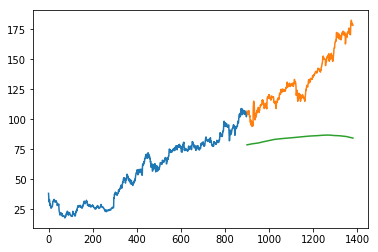

In [3]:
#plotting the value
%matplotlib inline
valid['Predictions'] = 0
valid['Predictions'] = preds
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])

## Inference

The result using the method of moving averages is not very promising.

## Linear Regression

The most basic machine learning algorithm that can be implemented on this data is linear regression. The linear regression model returns an equation that determines the relationship between the independent variables and the dependent variable.

We will use the date column to extract additional features and then fit a linear regression model.We will create features such as: ‘Year’, ‘Month’, ‘Week’, ‘Day’, ‘Dayofweek’, ‘Dayofyear’, ‘Is_month_end’, ‘Is_month_start’, ‘Is_quarter_end’, ‘Is_quarter_start’,  ‘Is_year_end’, and  ‘Is_year_start’.

We will first sort the dataset in ascending order and then create a separate dataset so that any new feature created does not affect the original data.

In [11]:
#setting index as date
df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
df.index = df['Date']

#setting index as date values
df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
df.index = df['Date']

#sorting
data = df.sort_index(ascending=True, axis=0)

#creating a separate dataset
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])

for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['Close'][i]

#create features
from fastai.structured import  add_datepart
add_datepart(new_data, 'Date')
new_data.drop('Elapsed', axis=1, inplace=True)  #elapsed will be the time stamp

new_data['mon_fri'] = 0
for i in range(0,len(new_data)):
    if (new_data['Dayofweek'][i] == 0 or new_data['Dayofweek'][i] == 4):
        new_data['mon_fri'][i] = 1
    else:
        new_data['mon_fri'][i] = 0
        
#split into train and validation
train = new_data[:900]
valid = new_data[900:]

x_train = train.drop('Close', axis=1)
y_train = train['Close']
x_valid = valid.drop('Close', axis=1)
y_valid = valid['Close']

##implement linear regression
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(x_train,y_train)

#make predictions and find the rmse
preds = model.predict(x_valid)
rms=np.sqrt(np.mean(np.power((np.array(y_valid)-np.array(preds)),2)))
print("Linear Regression RMS score is :" + str(rms))        
print("Linear Regression r-squared score is : " + str(r2_score(y_valid,preds)))


C:\Users\Biswadeep Sen\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Biswadeep Sen\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Linear Regression RMS score is :13.30661356367653
Linear Regression r-squared score is : 0.6443727906717304


C:\Users\Biswadeep Sen\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\Biswadeep Sen\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


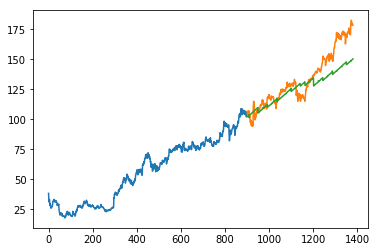

In [5]:
%matplotlib inline

#plot
valid['Predictions'] = 0
valid['Predictions'] = preds

valid.index = new_data[900:].index
train.index = new_data[:900].index

plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])

## Inference

Linear regression is a simple technique and quite easy to interpret, but there are a few obvious disadvantages. One problem in using regression algorithms is that the model overfits to the date and month column.Also in most case stock prices do not necessarily follow a linear trend.

## K-Nearest Neighbors

Another interesting ML algorithm that one can use here is kNN (k nearest neighbours). Based on the independent variables, kNN finds the similarity between new data points and old data points.

K-Nearest Neighbors is one of the most basic yet essential classification algorithms in Machine Learning. It belongs to the supervised learning domain and finds intense application in pattern recognition, data mining and intrusion detection.It is widely disposable in real-life scenarios since it is non-parametric, meaning, it does not make any underlying assumptions about the distribution of data (as opposed to other algorithms such as GMM, which assume a Gaussian distribution of the given data).

In k-NN regression, the output is the property value for the object. This value is the average of the values of its k nearest neighbors.

For each point in the validation set we find it's k nearest neighbors and it's predicted value will be the average of the closing prices of the k neighbors.

<img src="knn.png" alt="Alt text that describes the graphic" title="k-nearest neighbor" />


k nearest neighbors RMS : 67.23882182978588
K nearest neighbor r-squared score is : -8.080297599232418


C:\Users\Biswadeep Sen\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Biswadeep Sen\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


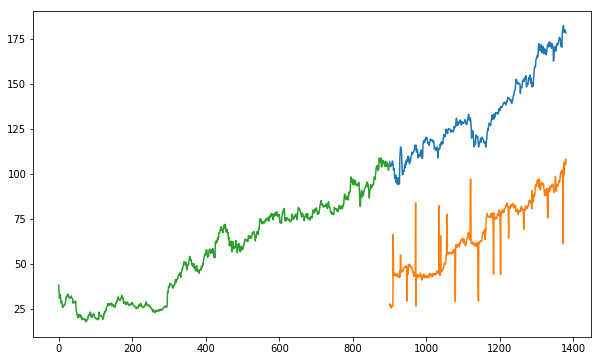

In [12]:
from sklearn import neighbors
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

#scaling data
x_train_scaled = scaler.fit_transform(x_train)
x_train = pd.DataFrame(x_train_scaled)
x_valid_scaled = scaler.fit_transform(x_valid)
x_valid = pd.DataFrame(x_valid_scaled)

#using gridsearch to find the best parameter
params = {'n_neighbors':[2,3,4,5,6,7,8,9]}
knn = neighbors.KNeighborsRegressor()
model = GridSearchCV(knn, params, cv=5)

#fit the model and make predictions
model.fit(x_train,y_train)
preds = model.predict(x_valid)

#rmse
rms=np.sqrt(np.mean(np.power((np.array(y_valid)-np.array(preds)),2)))
print("k nearest neighbors RMS : " + str(rms))
print("K nearest neighbor r-squared score is : " + str(r2_score(y_valid,preds)))

plt.rcParams['figure.figsize'] = [10,6]
#plot
valid['Predictions'] = 0
valid['Predictions'] = preds
plt.plot(valid[['Close', 'Predictions']])
plt.plot(train['Close'])

## Inference

It in general kNN performs very poorly on stock market datasets.

## FBProphet

 Prophet, designed and pioneered by Facebook, is a time series forecasting library that requires no data preprocessing and is extremely simple to implement. The input for Prophet is a dataframe with two columns: date and target (ds and y).

Prophet tries to capture the seasonality in the past data and works well when the dataset is large. 

We use a decomposable time series model with three main model components: trend, seasonality, and holidays. They are combined in the following equation:
y(t) = g(t) + s(t) + h(t) + e

 -  g(t) : piecewise linear or logistic growth curve for modelling non-periodic changes in time series
 -  s(t) : periodic changes (e.g. weekly/yearly seasonality)
 -  h(t) : effects of holidays (user provided) with irregular schedules
 -  e : error term accounts for any unusual changes not accommodated by the model
 
Using time as a regressor, Prophet is trying to fit several linear and non linear functions of time as components.
 
 

In [6]:
from fbprophet import Prophet

#creating dataframe
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])

for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['Close'][i]

new_data['Date'] = pd.to_datetime(new_data.Date,format='%Y-%m-%d')
new_data.index = new_data['Date']

#preparing data
new_data.rename(columns={'Close': 'y', 'Date': 'ds'}, inplace=True)

#train and validation
train = new_data[:900]
valid = new_data[900:]

#fit the model
model = Prophet(daily_seasonality = True)
model.fit(train)

#predictions
close_prices = model.make_future_dataframe(periods=len(valid))
forecast = model.predict(close_prices)

#rmse
forecast_valid = forecast['yhat'][900:]
rms=np.sqrt(np.mean(np.power((np.array(valid['y'])-np.array(forecast_valid)),2)))
print("Prophet RMS is : " + str(rms))
print("R-squared score is : " + str(r2_score(np.array(valid['y']),np.array(forecast_valid))))


C:\Users\Biswadeep Sen\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


Prophet RMS is : 10.804985227029814
R-squared score is : 0.7655186816783197


C:\Users\Biswadeep Sen\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Biswadeep Sen\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


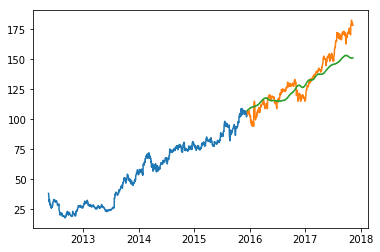

In [7]:
#plot
valid['Predictions'] = 0
valid['Predictions'] = forecast_valid.values

plt.plot(train['y'])
plt.plot(valid[['y', 'Predictions']])

## Inference

Prophet (like most time series forecasting techniques) tries to capture the trend and seasonality from past data. This model usually performs well on time series datasets.

As it turns out stock prices do not have a particular trend or seasonality. It highly depends on what is currently going on in the market and thus the prices rise and fall. Hence forecasting techniques like ARIMA and Prophet would not show good results in many cases.

## Auto ARIMA

ARIMA is a very popular statistical method for time series forecasting. ARIMA models take into account the past values to predict the future values. There are three important parameters in ARIMA:

 - p (past values used for forecasting the next value)
 - q (past forecast errors used to predict the future values)
 - d (order of differencing)

Order of differencing  specifies the number of times the differencing operation is performed on series to make it stationary.The data series is stationary, which means that the mean and variance should not vary with time. A series can be made stationary by using log transformation or differencing the series.The data provided as input must be a univariate series, since arima uses the past values to predict the future values.

Parameter tuning for ARIMA consumes a lot of time. So we will use auto ARIMA which automatically selects the best combination of (p,q,d) that provides the least error. 



Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=3008.238, BIC=3032.177, Fit time=6.960 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=3603.654, BIC=3613.230, Fit time=0.489 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=3354.436, BIC=3373.587, Fit time=2.884 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=3010.087, BIC=3029.239, Fit time=4.516 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=3008.246, BIC=3036.973, Fit time=5.820 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=3558.544, BIC=3577.695, Fit time=1.694 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=3007.939, BIC=3036.666, Fit time=16.832 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=3008.923, BIC=3032.863, Fit time=14.384 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_or

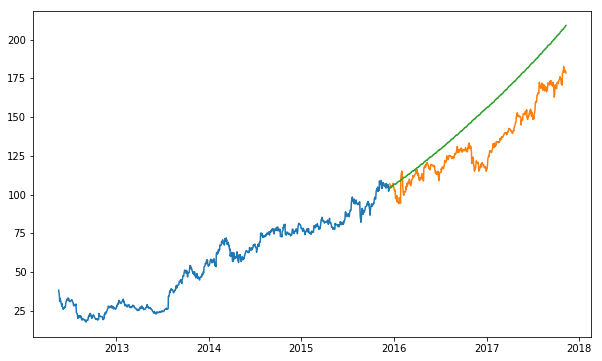

In [13]:
from pyramid.arima import auto_arima

data = df.sort_index(ascending=True, axis=0)

train = data[:900]
valid = data[900:]

training = train['Close']
validation = valid['Close']

model = auto_arima(training, start_p=1, start_q=1,max_p=3, max_q=3, m=12,start_P=0, seasonal=True,d=1, D=1, trace=True,error_action='ignore',suppress_warnings=True)
model.fit(training)

forecast = model.predict(n_periods=481)
forecast = pd.DataFrame(forecast,index = valid.index,columns=['Prediction'])

rms=np.sqrt(np.mean(np.power((np.array(valid['Close'])-np.array(forecast['Prediction'])),2)))
print("ARIMA RMS is : " + str(rms))
print("R-squared score is : " + str(r2_score(np.array(valid['Close']),np.array(forecast['Prediction']))))
#plot ARIMSA
plt.plot(train['Close'])
plt.plot(valid['Close'])
plt.plot(forecast['Prediction'])

In [ ]:
## Inference 

As we saw earlier, an auto ARIMA model uses past data to understand the pattern in the time series. 
Using these values, the model captured an increasing trend in the series.But still the predictions are not close to the real values.



## Long Short Term Memory(LSTM)

LSTMs are widely used for sequence prediction problems and have proven to be extremely effective. The reason they work so well is because LSTM is able to store past information that is important, and forget the information that is not. LSTM has three gates:

 - The input gate: The input gate adds information to the cell state
 - The forget gate: It removes the information that is no longer required by the model
 - The output gate: Output Gate at LSTM selects the information to be shown as output
 
With LSTMs, the information flows through a mechanism known as cell states. This way, LSTMs can selectively remember or forget things.

C:\Users\Biswadeep Sen\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
C:\Users\Biswadeep Sen\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


Epoch 1/1
 - 68s - loss: 0.0013
LSTM 8.129609508133731
LSTM r-squared score is : 0.86726077939449


C:\Users\Biswadeep Sen\Anaconda3\lib\site-packages\ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


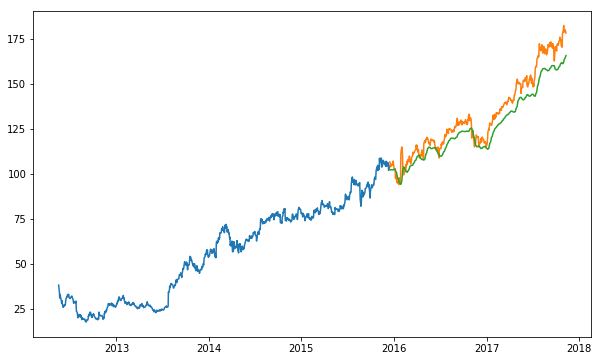

In [14]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
#
#creating dataframe
data = df.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])
for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['Close'][i]

#setting index
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)

#creating train and test sets
dataset = new_data.values

train = dataset[0:900,:]
valid = dataset[900:,:]

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
##
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)

#predicting remaining values, using past 60 from the train data
inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
print("LSTM " + str(rms))
print("LSTM r-squared score is : " + str(r2_score(valid,closing_price)))

#for plotting LSTM
train = new_data[:900]
valid = new_data[900:]
valid['Predictions'] = closing_price
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])

## Inference

LSTM performs the best among all other methods when it comes to predicting the closing price of a stock.
But stock price is affected by the news about the company and other factors like demonetization or merger/demerger of the companies. There are certain intangible factors as well which can often be impossible to predict beforehand.